## Multi-label prediction with Planet Amazon dataset

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *

## Getting the data

The planet dataset isn't available on the [fastai dataset page](https://course.fast.ai/datasets) due to copyright restrictions. You can download it from Kaggle however. Let's see how to do this by using the [Kaggle API](https://github.com/Kaggle/kaggle-api) as it's going to be pretty useful to you if you want to join a competition or use other Kaggle datasets later on.

First, install the Kaggle API by uncommenting the following line and executing it, or by executing it in your terminal (depending on your platform you may need to modify this slightly to either add `source activate fastai` or similar, or prefix `pip` with a path. Have a look at how `conda install` is called for your platform in the appropriate *Returning to work* section of https://course.fast.ai/. (Depending on your environment, you may also need to append "--user" to the command.)

In [3]:
#! {sys.executable} -m pip install kaggle --upgrade

Requirement already up-to-date: kaggle in /home/user/anaconda3/envs/deeplearning/lib/python3.7/site-packages (1.5.6)


Then you need to upload your credentials from Kaggle on your instance. Login to kaggle and click on your profile picture on the top left corner, then 'My account'. Scroll down until you find a button named 'Create New API Token' and click on it. This will trigger the download of a file named 'kaggle.json'.

Upload this file to the directory this notebook is running in, by clicking "Upload" on your main Jupyter page, then uncomment and execute the next two commands (or run them in a terminal). For Windows, uncomment the last two commands.

In [8]:
# ! mkdir -p ~/.kaggle/
# ! mv kaggle.json ~/.kaggle/

# #For Windows, uncomment these two commands
# ! mkdir %userprofile%\.kaggle
# ! move kaggle.json %userprofile%\.kaggle

mv: 'kaggle.json'를 설명할 수 없음: 그런 파일이나 디렉터리가 없습니다
mkdir: `%userprofile%.kaggle' 디렉토리를 만들 수 없습니다: 파일이 있습니다
/bin/sh: 1: move: not found


You're all set to download the data from [planet competition](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space). You **first need to go to its main page and accept its rules**, and run the two cells below (uncomment the shell commands to download and unzip the data). If you get a `403 forbidden` error it means you haven't accepted the competition rules yet (you have to go to the competition page, click on *Rules* tab, and then scroll to the bottom to find the *accept* button).

In [19]:
path = Config.data_path()/'planet' # fastai 디렉토리 생성후 planet 폴더 생성.
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/home/user/.fastai/data/planet')

In [23]:
#! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p {path}
#! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv -p {path}
#! unzip -q -n {path}/train_v2.csv.zip -d {path}

unzip:  cannot find or open /home/user/.fastai/data/planet/train_v2.csv.zip, /home/user/.fastai/data/planet/train_v2.csv.zip.zip or /home/user/.fastai/data/planet/train_v2.csv.zip.ZIP.


To extract the content of this file, we'll need 7zip, so uncomment the following line if you need to install it (or run `sudo apt install p7zip-full` in your terminal).

In [27]:
#! conda install --yes --prefix {sys.prefix} -c haasad eidl7zip  # 7z 압축파일을 풀기 위한 라이브러리 설치.

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.2
  latest version: 4.8.3

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/user/anaconda3/envs/deeplearning

  added / updated specs:
    - eidl7zip


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    eidl7zip-1.0.0             |                1         565 KB  haasad
    ------------------------------------------------------------
                                           Total:         565 KB

The following NEW packages will be INSTALLED:

  eidl7zip           haasad/linux-64::eidl7zip-1.0.0-1



eidl7zip-1.0.0       | 565 KB    | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done


And now we can unpack the data (uncomment to run - this might take a few minutes to complete).

In [28]:
#! 7za -bd -y -so x {path}/train-jpg.tar.7z | tar xf - -C {path.as_posix()} # 7z 대용량 데이터 압축해제.

## Multiclassification

Contrary to the pets dataset studied in last lesson, here each picture can have multiple labels. If we take a look at the csv file containing the labels (in 'train_v2.csv' here) we see that each 'image_name' is associated to several tags separated by spaces.

In [29]:
df = pd.read_csv(path/'train_v2.csv') # train_v2.csv에는 각 이미지별 label 정보가 있음.
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


To put this in a `DataBunch` while using the [data block API](https://docs.fast.ai/data_block.html), we then need to using `ImageList` (and not `ImageDataBunch`). This will make sure the model created has the proper loss function to deal with the multiple classes.

In [30]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

We use parentheses around the data block pipeline below, so that we can use a multiline statement without needing to add '\\'.

In [31]:
np.random.seed(42)
src = (ImageList.from_csv(path, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' ')) # ImageList.from_csv 함수로 특정 폴더에 존재하는 모든 jpg 파일을 불러올 수 있다.

In [32]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats)) # ImageNet에서 사용하는 기준으로 data preprocessing.

`show_batch` still works, and show us the different labels separated by `;`.

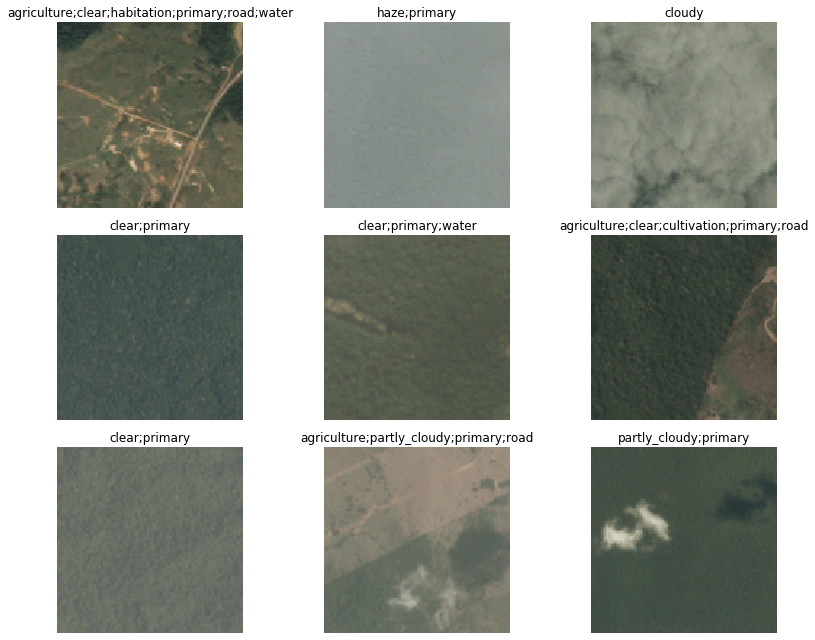

In [33]:
data.show_batch(rows=3, figsize=(12,9))

To create a `Learner` we use the same function as in lesson 1. Our base architecture is resnet50 again, but the metrics are a little bit differeent: we use `accuracy_thresh` instead of `accuracy`. In lesson 1, we determined the predicition for a given class by picking the final activation that was the biggest, but here, each activation can be 0. or 1. `accuracy_thresh` selects the ones that are above a certain threshold (0.5 by default) and compares them to the ground truth.

As for Fbeta, it's the metric that was used by Kaggle on this competition. See [here](https://en.wikipedia.org/wiki/F1_score) for more details.

In [34]:
arch = models.resnet50 # ResNet 50으로 학습.

In [35]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2) # precision과 recall의 조화평균인 F1-score.
learn = cnn_learner(data, arch, metrics=[acc_02, f_score])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/user/.cache/torch/checkpoints/resnet50-19c8e357.pth


We use the LR Finder to pick a good learning rate.

In [36]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


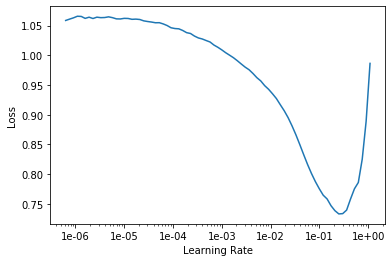

In [37]:
learn.recorder.plot() # 대략 0.5 정도에서 최저 loss.

Then we can fit the head of our network.

In [38]:
lr = 0.01

In [39]:
learn.fit_one_cycle(5, slice(lr)) # 5 epoch 학습.

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.136060,0.117644,0.939265,0.897412,00:34
1,0.111259,0.098651,0.949206,0.915995,00:34
2,0.103975,0.094316,0.956219,0.918957,00:34
3,0.093995,0.088456,0.955441,0.924291,00:34
4,0.091809,0.087278,0.955150,0.924940,00:34


In [40]:
learn.save('stage-1-rn50')

...And fine-tune the whole model:

In [41]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


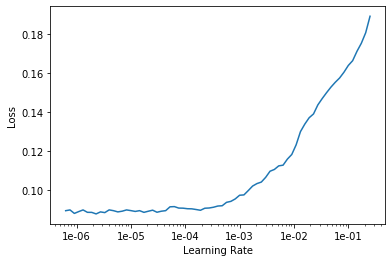

In [42]:
learn.lr_find()
learn.recorder.plot()

In [43]:
learn.fit_one_cycle(5, slice(1e-5, lr/5)) # lr을 다르게 주고 5 epoch 학습.

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.096778,0.092399,0.955463,0.920315,00:47
1,0.095476,0.089000,0.955979,0.922726,00:47
2,0.094818,0.085045,0.955943,0.926758,00:47
3,0.084191,0.083537,0.958050,0.928176,00:47
4,0.082667,0.083124,0.958311,0.929067,00:47


In [44]:
learn.save('stage-2-rn50')

In [45]:
data = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats)) # 이번엔 사이즈를 128x128에서 256x256으로 4배 증가.

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [46]:
learn.freeze()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


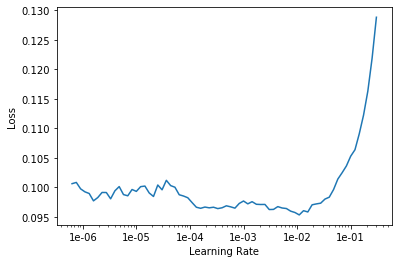

In [47]:
learn.lr_find()
learn.recorder.plot()

In [48]:
lr=1e-2/2 # recorder.plot으로 확인할 수 있는건, (당연히)데이터가 바뀌면 LR initial setting도 바뀌어야함. 아까보다 더 적은 LR에서 최소를 가지며, 이전과 비슷한 값에서는 loss가 엄청나게 커지는것을 볼 수 있음.

In [49]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.087888,0.086040,0.954707,0.925011,02:02
1,0.086980,0.085510,0.959794,0.926145,02:02
2,0.084488,0.083676,0.957083,0.927697,02:02
3,0.082724,0.082021,0.960622,0.930774,02:02
4,0.082100,0.081822,0.960230,0.931234,02:02


In [50]:
learn.save('stage-1-256-rn50')

In [51]:
learn.unfreeze()

In [52]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.087167,0.084674,0.958783,0.928502,02:43
1,0.084183,0.085830,0.957861,0.925449,02:42
2,0.083534,0.081987,0.958973,0.928932,02:42
3,0.075723,0.081384,0.959547,0.930694,02:43
4,0.074674,0.081004,0.959321,0.931620,02:42


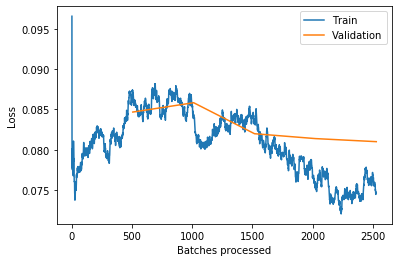

In [53]:
learn.recorder.plot_losses() # validation loss가 어느정도는 train loss를 따라감. 학습이 잘되는중.

In [54]:
learn.save('stage-2-256-rn50')

You won't really know how you're going until you submit to Kaggle, since the leaderboard isn't using the same subset as we have for training. But as a guide, 50th place (out of 938 teams) on the private leaderboard was a score of `0.930`.

In [55]:
learn.export() # 밑에 있는 파트2 내용까지 끝나야 kaggle에 submission 가능.

## Short Comment:

- 실제 kaggle에서 competition이 진행되었던 데이터를 사용하여 classification 해보는 예제라 재밌었다.
- 역시 ResNet으로 돌리면 기본으로 어느정도의 높은 score는 보장되는 것 같다. 이제 CV는 그냥 ResNet과 UNet 세상이다.
- part1에서는 그냥 세팅하고 돌려보는게 끝이라, 아쉬웠고 part2에서 submission을 위한 여러가지 학습 장치들을 익혀보고 싶다.

## fin

(This section will be covered in part 2 - please don't ask about it just yet! :) )

In [ ]:
#! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg.tar.7z -p {path}  
#! 7za -bd -y -so x {path}/test-jpg.tar.7z | tar xf - -C {path}
#! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg-additional.tar.7z -p {path}  
#! 7za -bd -y -so x {path}/test-jpg-additional.tar.7z | tar xf - -C {path}

In [ ]:
test = ImageList.from_folder(path/'test-jpg').add(ImageList.from_folder(path/'test-jpg-additional'))
len(test)

61191

In [ ]:
learn = load_learner(path, test=test)
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [ ]:
thresh = 0.2
labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]

In [ ]:
labelled_preds[:5]

['agriculture cultivation partly_cloudy primary road',
 'clear haze primary water',
 'agriculture clear cultivation primary',
 'clear primary',
 'partly_cloudy primary']

In [ ]:
fnames = [f.name[:-4] for f in learn.data.test_ds.items]

In [ ]:
df = pd.DataFrame({'image_name':fnames, 'tags':labelled_preds}, columns=['image_name', 'tags'])

In [ ]:
df.to_csv(path/'submission.csv', index=False)

In [ ]:
! kaggle competitions submit planet-understanding-the-amazon-from-space -f {path/'submission.csv'} -m "My submission"

100%|██████████████████████████████████████| 2.18M/2.18M [00:02<00:00, 1.05MB/s]
Successfully submitted to Planet: Understanding the Amazon from Space

Private Leaderboard score: 0.9296 (around 80th)